# **토릭모델링_1**
                                                note by D.H.Yeom

#1.라이브러리 & 데이터

In [1]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 50.7 MB/s eta 0:00:00


In [2]:
#!pip install matplotlib
#!pip install wordcloud

import pandas as pd
import numpy as np

from collections import Counter
from konlpy.tag import Kkma
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
Kkma=Kkma()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [4]:
#df1 = pd.read_excel('')
#df1=pd.read_excel("/content/drive/MyDrive/DataSet_2022/")

In [8]:
df = pd.read_csv("/content/sample_data/creativity.csv")

In [9]:
df.head(2)

,description
0,MBTI와 창의성에 대하여 ※ 주의 : 슬픈 진실이 포함되어 있습니다. ※ 이로인해...
1,종치면 들어가서 교육받고 종치면 나오고...초중고품아가 아이들 창의성에 어떤 영향을...


In [10]:
df.tail(2)

,description
128,nhn)이용바랍니다 -----------------------------------...
129,삼성창의성면접 : 알아보고 100% 준비보아요!! 안녕하세요. 내일코칭스쿨입니다. ...


In [11]:
df.iloc[[1]]

,description
1,종치면 들어가서 교육받고 종치면 나오고...초중고품아가 아이들 창의성에 어떤 영향을...


In [19]:
df1 = df.reset_index(drop=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  130 non-null    object
dtypes: object(1)
memory usage: 1.1+ KB


In [12]:
!pip install transformers

In [13]:
import tensorflow as tf

In [14]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print("GPU 작동 중")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU 미작동 중")

GPU 작동 중


###**------------------------**

# 2.데이터 전처리

* 불용어 처리

[정규표현식 참조](https://settlelib.tistory.com/58)

In [15]:
import re

def regular_expression(text):          # 정규표현식 적용
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')    # 한글의 정규표현식을 리턴(한글과 띄어쓰기를 제외한 모든 글자)
    result = hangul.sub('', text)            # 한글과 띄어쓰기를 제외한 모든 부분 제거
    return result

In [20]:
df1['description'][0]

'MBTI와 창의성에 대하여 ※ 주의 : 슬픈 진실이 포함되어 있습니다. ※ 이로인해 기분이 안 좋아지실 수 있습니다.※ 1700자 분량의 긴 글입니다. 창의성과 성격에 대해 말씀하시는 분들 중에 N이 창의성이라 말씀하시는... '

In [21]:
regular_expression(df1['description'][0])

'와 창의성에 대하여  주의  슬픈 진실이 포함되어 있습니다  이로인해 기분이 안 좋아지실 수 있습니다 자 분량의 긴 글입니다 창의성과 성격에 대해 말씀하시는 분들 중에 이 창의성이라 말씀하시는 '

In [22]:
from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(regular_expression(df1['description'][0]))
print(nouns)

['창의성', '대하', '주의', '진실', '포함', '기분', '안', '수', '자', '분량', '글', '창의성', '성격', '대해', '말씀', '중', '이', '창의성', '말씀']


In [23]:
words = nouns_tagger.nouns(regular_expression("".join(df1['description'].tolist())))

counter = Counter(words)
counter.most_common(10)

[('창의성', 220),
 ('면접', 70),
 ('거래', 54),
 ('판매', 52),
 ('언어', 46),
 ('권', 44),
 ('아이', 42),
 ('교원', 41),
 ('책', 34),
 ('가격', 33)]

In [24]:
word1 = Counter({x : counter[x] for x in counter if len(x) > 1})
word1.most_common(10)

[('창의성', 220),
 ('면접', 70),
 ('거래', 54),
 ('판매', 52),
 ('언어', 46),
 ('아이', 42),
 ('교원', 41),
 ('가격', 33),
 ('개인', 25),
 ('삼성', 25)]

In [25]:
stop_words=["지난번", "창의성", "ㅋ", "^^", "대해", "대하", "중에서", "000원", "판매", "가격", "그", "등", "이로", "저희", "있는", "기반으로", "이승헌", "뇌교육의", "위한",
            "있다", "통해", "뇌를", "우리", "BR뇌교육", "대한", "엘살바도르",
           "안녕하세요", "하는", "com", "하고", "IBREA","많이"]

#stop_words = stop_words.split(',')

# 데이터 특징을 반영한 불용어 추가
#creat_stopwords = ['판매', '창의성', '가격']
#for word in creat_stopwords:
    #stop_words.append(word1)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer     #sklearn 사용
from konlpy.tag import Okt      #형태소 분석
twit = Okt()

def tokenizer(description):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')     #정규식
    result = hangul.sub('', description)
    tagger = Okt()
    word1 = nouns_tagger.nouns(result)
    word1 = [x for x in words if len(x) > 1]
    word1 = [x for x in words if x not in stop_words]
    return word1

#def tokenizer(description):
    #return [token for token in twit.nouns(description) if len(token) > 1]

vect = CountVectorizer(tokenizer = tokenizer)             #, max_df = 0.5, min_df = 5, #max_features = 100)
bow_vect = vect.fit_transform(df1['description'].tolist())

word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

print(bow_vect.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(130, 971)


In [27]:
%matplotlib inline

import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

###**-----------------------**

# 3.토픽 모델링

##3.1 Gensim을 이용한 토픽 모델링

* [Gensim](https://radimrehurek.com/gensim/) 은 Python 으로 구현된 topic modeling / embedding 용 라이브러리이다.
* pyLDAvis 를 이용하기 위해서는 일단 LDA 를 학습해야 한다.

In [28]:
from collections.abc import Mapping
from collections.abc import MutableMapping
from collections.abc import Sequence

In [29]:
#!pip install gensim==3.6.0
!pip install gensim
from gensim import corpora, models
from gensim import corpora
import gensim

# 형태소 분석
df2=[]
for i in range(len(df1)):
    try:
        df2.append(Kkma.nouns(df1["description"][i]))
    except Exception as e:
        continue
#df2[1:2]

df2=[[y for y in x if len(y) > 1]
     for x in df2]

dictionary = corpora.Dictionary(df2)                 # dictionary 생성(토큰화 결과 + id(gensim 내부) 결합)
corpus = [dictionary.doc2bow(text) for text in df2]  # doc2bow:count Vectorizer 기능(사이킷런) 변환

print('#Number of unique token: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of unique token: 1227
#Number of documents: 130


In [30]:
import matplotlib.pyplot as plt

from gensim.models import LdaModel

num_topics = 10
passes = 5
model = LdaModel(corpus = corpus, num_topics=num_topics , id2word = dictionary, passes = passes, random_state = 7)

model.print_topics(num_words = 5)

[(0, '0.030*"창의성" + 0.012*"창의" + 0.012*"내용" + 0.009*"교육" + 0.008*"교원"'),
 (1, '0.019*"창의성" + 0.010*"창의" + 0.005*"교육" + 0.005*"20권" + 0.005*"가격"'),
 (2, '0.040*"창의성" + 0.019*"아이" + 0.010*"창의" + 0.008*"생각" + 0.008*"자료"'),
 (3, '0.025*"창의성" + 0.015*"아이" + 0.015*"면접" + 0.010*"저희" + 0.010*"시간"'),
 (4, '0.039*"창의성" + 0.025*"창의" + 0.010*"아이" + 0.008*"교육" + 0.008*"문제"'),
 (5, '0.036*"창의성" + 0.013*"개인" + 0.009*"교육" + 0.009*"판매" + 0.009*"개인거래"'),
 (6, '0.023*"창의성" + 0.011*"거래" + 0.011*"상품" + 0.011*"상태" + 0.010*"하세"'),
 (7, '0.035*"창의성" + 0.018*"면접" + 0.017*"삼성" + 0.015*"준비" + 0.013*"창의성면접"'),
 (8, '0.031*"가격" + 0.030*"거래" + 0.030*"개인거래" + 0.030*"판매" + 0.030*"개인"'),
 (9, '0.042*"창의성" + 0.013*"아이" + 0.008*"안전" + 0.008*"사용" + 0.007*"전집"')]

###3.2 토픽 모델링 시각화

In [31]:
!pip install pyLDAvis==3.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135594 sha256=4986859c3294732e7effd421165d032c69264e17dd4152ea179c6a43b7820615
  Stored in directory: /root/.cache/pip/wheels/20/a4/75/e8ae5c16ebb85de43dfa0f238db03b19592fa4b3063882bb14
Successfully built pyLDAvis


In [32]:
import pyLDAvis
import pyLDAvis.gensim

# LDA 모델을 pyLDAvis 객체에 전달
pyLDAvis.enable_notebook()
lda_viz = pyLDAvis.gensim.prepare(model, corpus, dictionary)
lda_viz

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.237302 -0.006242       1        1  18.135100
5      0.050925 -0.034008       2        1  16.378581
0     -0.050488  0.114083       3        1  12.411409
4     -0.084402 -0.118723       4        1  10.996441
6     -0.015323  0.109462       5        1  10.551395
2     -0.033897  0.007418       6        1  10.539411
9      0.034427 -0.044852       7        1   7.379386
7     -0.057892 -0.011179       8        1   5.931979
1     -0.013558  0.013213       9        1   3.936366
3     -0.067095 -0.029171      10        1   3.739932, topic_info=     Term       Freq      Total Category  logprob  loglift
308    사용  15.000000  15.000000  Default  30.0000  30.0000
16     안전  15.000000  15.000000  Default  29.0000  29.0000
307   미사용  14.000000  14.000000  Default  28.0000  28.0000
310  안전거래  14.000000  14.000000  Default  27.0000  27.0000
44     개인  20.000000  20.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
482    색감   0.484657   1.722446  Topic10  -5.2416   2.0180
485    우선   0.484656   1.526279  Topic10  -5.2416   2.1390
332    부모   0.484656   2.412503  Topic10  -5.2416   1.6811
503    잡스   0.484656   2.372523  Topic10  -5.2416   1.6978
437    진행   0.484656   4.255508  Topic10  -5.2416   1.1136

[571 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
603       5  0.759848     0.8
173       6  0.780231     01공
174       1  0.649111      10
174       3  0.144247      10
174       5  0.072123      10
...     ...       ...     ...
81        6  0.224094      활동
81        7  0.224094      활동
81        8  0.224094      활동
237       9  0.921120     활성화
775       6  0.780230  흥미가지나요

[725 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 1, 5, 7, 3, 10, 8, 2, 4])

# 4.모델평가

##4.1 토픽 응집도(coherence score)
* 값이 클수록 정확한 데이터


In [33]:
import matplotlib.pyplot as plt

from gensim.models import CoherenceModel
cm = CoherenceModel(model=model, texts=df2, coherence='u_mass', topn=10, dictionary=dictionary)
coherence = cm.get_coherence()
print(coherence)

-7.111076970916274


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

coherence_values=[]
for i in range(2,15):
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=i)
    cm = CoherenceModel(model=ldamodel, texts=df2, coherence='u_mass', topn=i, dictionary=dictionary)
    coherence = cm.get_coherence()
    coherence_values.append(coherence)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


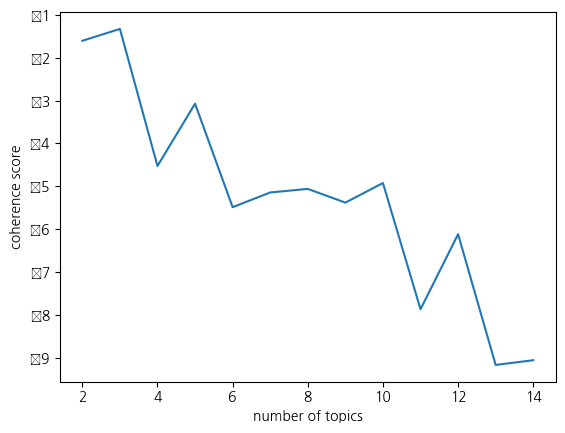

In [35]:
x=range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

## 4.2 혼란도(perplexity score)
*  값이 작을수록 정확한 데이터

In [36]:
import matplotlib.pyplot as plt

perplexity_values=[]
for i in range(2,15):
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


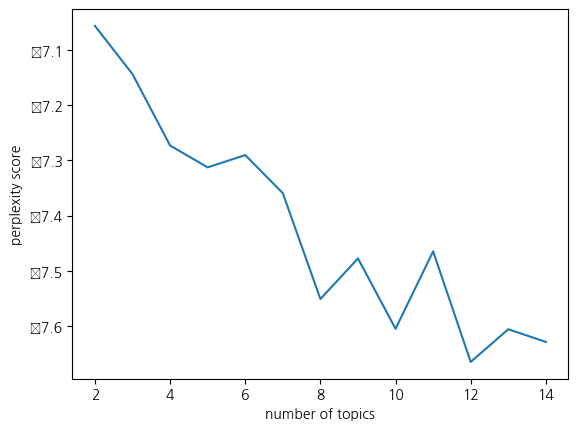

In [37]:
x=range(2,15)
plt.plot(x, perplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 6, perplexity: -7.398, coherence: -8.912


num_topics: 7, perplexity: -7.445, coherence: -9.546


num_topics: 8, perplexity: -7.469, coherence: -10.032


num_topics: 9, perplexity: -7.532, coherence: -9.611


num_topics: 10, perplexity: -7.529, coherence: -9.289
num_topics: 11, perplexity: -7.635, coherence: -9.538


num_topics: 12, perplexity: -7.561, coherence: -9.916


num_topics: 13, perplexity: -7.672, coherence: -9.676


num_topics: 14, perplexity: -7.672, coherence: -9.976
num_topics: 15, perplexity: -7.673, coherence: -9.926


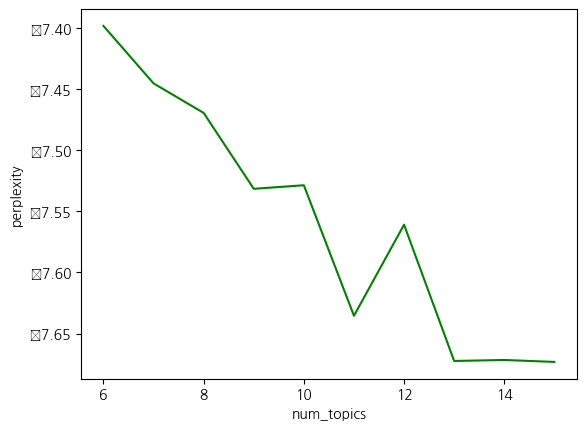

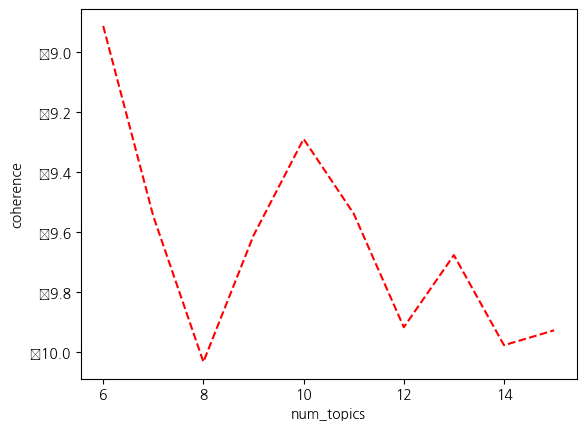

In [ ]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary, chunksize=1000, num_topics=i, random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)

        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel('num_topics')
    plt.ylabel('perplexity')
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel('num_topics')
    plt.ylabel('coherence')
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

##4.3 모델수정

In [38]:
# 위의 결과들 바탕으로 갯수 수정하기
model=gensim.models.ldamodel.LdaModel(corpus, num_topics=8,
                                         id2word=dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
model.print_topics(num_words=5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '0.035*"창의성" + 0.017*"면접" + 0.012*"창의" + 0.011*"삼성" + 0.009*"인성"'),
 (1, '0.019*"창의성" + 0.009*"교육" + 0.007*"창의" + 0.007*"아이" + 0.007*"첫째"'),
 (2, '0.018*"창의성" + 0.010*"교육" + 0.009*"교원" + 0.009*"거래" + 0.009*"가격"'),
 (3, '0.045*"창의성" + 0.012*"언어" + 0.011*"창의" + 0.010*"가격" + 0.010*"아이"'),
 (4, '0.028*"창의성" + 0.011*"개인" + 0.010*"판매" + 0.009*"가격" + 0.009*"안전거래"'),
 (5, '0.029*"창의성" + 0.017*"거래" + 0.015*"가격" + 0.015*"개인" + 0.013*"언어"'),
 (6, '0.030*"창의성" + 0.012*"창의" + 0.011*"교원" + 0.008*"가격" + 0.008*"거래"'),
 (7, '0.039*"창의성" + 0.023*"아이" + 0.012*"생각" + 0.009*"교육" + 0.008*"우리"')]

In [40]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

coherence_values=[]
for i in range(2,15):
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=12, id2word=dictionary, random_state=i)
    cm = CoherenceModel(model=ldamodel, texts=df2, coherence='u_mass', topn=12, dictionary=dictionary)
    coherence = cm.get_coherence()
    coherence_values.append(coherence)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


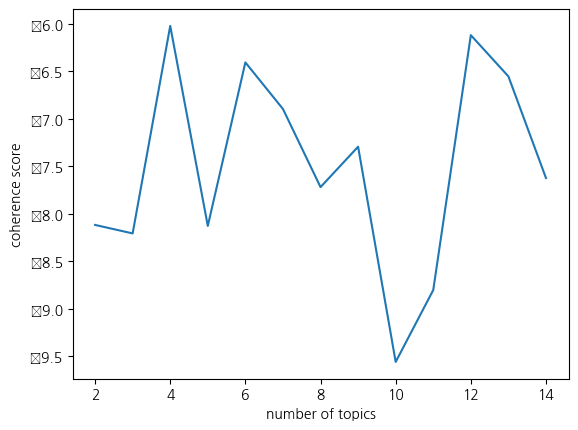

In [41]:
x=range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [42]:
import pyLDAvis
import pyLDAvis.gensim

# LDA 모델을 pyLDAvis 객체에 전달
pyLDAvis.enable_notebook()
lda_viz = pyLDAvis.gensim.prepare(model, corpus, dictionary)
lda_viz

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.106443  0.021595       1        1  19.887194
3     -0.001114 -0.088695       2        1  16.789696
0     -0.137765  0.077760       3        1  14.671261
7     -0.069318 -0.097383       4        1  11.899335
4      0.063963  0.004549       5        1  10.527829
2      0.021080  0.040557       6        1  10.302814
6      0.016349  0.025254       7        1   8.940787
1      0.000361  0.016363       8        1   6.981085, topic_info=     Term       Freq      Total Category  logprob  loglift
12     생각   8.000000   8.000000  Default  30.0000  30.0000
253    면접  12.000000  12.000000  Default  29.0000  29.0000
14     아이  19.000000  19.000000  Default  28.0000  28.0000
255    삼성   9.000000   9.000000  Default  27.0000  27.0000
436    준비   6.000000   6.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
46     거래   0.816953  20.368099   Topic8  -5.3436  -0.5542
43     가격   0.731112  20.888805   Topic8  -5.4547  -0.6904
409  계신가여   0.602962   2.026605   Topic8  -5.6474   1.4497
77     엄마   0.602938   3.187816   Topic8  -5.6474   0.9967
291    작년   0.602934   2.026662   Topic8  -5.6474   1.4496

[535 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
328       4  0.801183       001
172       2  0.740509        01
273       1  0.670838  010.3373
605       2  0.494204       1.2
174       1  0.321077        10
...     ...       ...       ...
838       2  0.740491        확장
81        4  0.463058        활동
81        6  0.231529        활동
775       7  0.839853    흥미가지나요
336       4  0.801164      힘창의성

[679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 1, 8, 5, 3, 7, 2])

###**-------------------**

#4.결과 분석

##4.1 토픽 설명정도 확인

In [43]:
#문장의 결과(토픽별 설명정도)에 대한 설명정도(%)
ldamodel.get_document_topics(corpus)[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(3, 0.93888575)]

In [44]:
ldamodel.get_document_topics(corpus)[10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(10, 0.95634615)]

In [46]:
ldamodel.get_document_topics(corpus)[100]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(4, 0.9541651)]

##4.2 연관어 분석

In [47]:
from gensim.models.word2vec import Word2Vec
model=Word2Vec(df2, sg=1, window=10, min_count=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
model.init_sims(replace=True)
model.wv.most_similar("시기",topn=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-48-8e4a3799da1d>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)
/usr/local/lib/python3.10/dist-packages/gensim/models/word2vec.py:913: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.wv.init_sims(replace=repla

[('창의성면접', 0.7652361989021301),
 ('상태', 0.757523775100708),
 ('생각', 0.7563689947128296),
 ('10권', 0.755499005317688),
 ('창의성', 0.7552787065505981),
 ('아이', 0.7551597356796265),
 ('사용', 0.7538549304008484),
 ('지원', 0.7537661790847778),
 ('10', 0.7535189986228943),
 ('유아', 0.7501825094223022)]

In [49]:
model.wv.similarity("창의성", "인성")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9509744

###**----------------------**

# 5.Q & A

# 굿럭!!